# Basketball Fantasy League Recommender System

This Jupyter notebook is part of a comprehensive educational project that demonstrates the integration of data engineering and machine learning concepts. The project showcases three key components: API development, ETL (Extract, Transform, Load) processes, and recommender systems. Specifically, we leverage a custom-built BasketballAPI that generates fictional basketball player data and statistics across multiple seasons by simulating the `nba_api` which is an API Client for www.nba.com. This data is then processed through a Python-based ETL pipeline that cleanly transforms and stores the information in a CSV format. 

The project follows the CRISP-DM (Cross-Industry Standard Process for Data Mining) methodology, which provides a structured approach through six key phases:
1. **Business Understanding**: Defining the need for a fantasy basketball recommender system
2. **Data Understanding**: Analyzing the BasketballAPI data structure and statistical patterns
3. **Data Preparation**: ETL processes to clean and transform the raw API data
4. **Modeling**: Implementing various recommender system algorithms
5. **Evaluation**: Testing the recommendations' accuracy and relevance
6. **Deployment**: Creating a usable system for fantasy basketball managers

While the project encompasses multiple technical aspects, this notebook primarily focuses on building and evaluating different recommender system techniques to suggest similar players based on their statistical performance and characteristics. This practical approach allows us to explore real-world applications of data science while working with a controlled, yet realistic dataset that simulates five seasons of basketball data across 390 players and multiple teams.

### Import Modules - Loading Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
pd.set_option('display.max_colwidth', 800)
%matplotlib inline

In [3]:
df = pd.read_csv('basketball_data.csv')

### Exploratory Data Analysis (EDA)

In [5]:
df.head()

,player_id,player_name,archetype,season,team,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
0,0,Robert Smith,regular,2019-20,SkyBirds,55,36.3,5.4,3.9,NaN,1.2,0.2,0.400,0.302,0.709
1,1,Mandy Evans,regular,2019-20,SparkiFY,38,14.8,17.9,5.9,3.9,1.6,0.5,0.431,0.369,0.734
2,2,Miguel Lee,regular,2019-20,SkyBirds,79,17.2,10.1,7.2,2.5,1.4,1.2,0.432,0.322,0.792
3,3,Ashlee Martin,regular,2019-20,HtmlERS,46,31.6,11.6,7.0,3.5,0.5,1.1,0.474,0.365,0.739
4,4,David Hamilton,regular,2019-20,SparkiFY,37,31.9,8.9,6.4,NaN,1.7,0.8,0.433,0.329,NaN


In [6]:
print(f" The dataframe has {df.shape[0]} records and {df.shape[1]} attributes.")

 The dataframe has 1950 records and 15 attributes.


In [7]:
df.dtypes

player_id         int64
player_name      object
archetype        object
season           object
team             object
games_played      int64
minutes         float64
points          float64
rebounds        float64
assists         float64
steals          float64
blocks          float64
fg_pct          float64
fg3_pct         float64
ft_pct          float64
dtype: object

#### <i>Does this dataframe present duplicate values? </i>

In [64]:
print(f"The dataframe should contain {df.player_id.nunique()} unique player")

The dataframe should contain 390 unique player


In [62]:
df.groupby('season')['player_id'].count()

season
2019-20    390
2020-21    390
2021-22    390
2022-23    390
2023-24    390
Name: player_id, dtype: int64

The dataframe should contain 390 unique player


#### <i>Does the dataframe presents any null values?</i>


In [26]:
df.isnull().any()

player_id       False
player_name     False
archetype       False
season          False
team            False
games_played    False
minutes         False
points           True
rebounds         True
assists          True
steals           True
blocks           True
fg_pct           True
fg3_pct          True
ft_pct           True
dtype: bool

In [38]:
print(f" There are {df.isnull().any().sum()} attribues with missing values")

 There are 8 attribues with missing values


In [45]:
#(df.isnull().sum() / df.shape[0])
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  
print(missing_percentage)


points      5.435897
rebounds    5.435897
assists     5.538462
steals      4.358974
blocks      4.205128
fg_pct      3.538462
fg3_pct     5.384615
ft_pct      5.230769
dtype: float64


In [48]:
print(f" On average these fields have {round(missing_percentage.mean(),1)} of missing values")

 On average these fields have 4.9 of missing values


####  <i>This is something to keep into account as we develop our models.Next we to observe the distributions of some attributes. Now let's look at some summary statics.</i>

In [58]:
df.iloc[:,1:].describe()

,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
count,1950.000000,1950.000000,1844.000000,1844.000000,1842.000000,1865.000000,1868.000000,1881.000000,1845.000000,1848.000000
mean,51.735385,25.105949,11.420174,4.495824,3.033659,1.009330,0.641328,0.446874,0.330622,0.752390
std,18.249953,7.595495,5.761876,1.934746,1.938258,0.537009,0.426800,0.048509,0.036472,0.067144
min,20.000000,12.100000,2.000000,1.000000,0.500000,0.000000,0.000000,0.350000,0.250000,0.601000
25%,36.000000,18.400000,7.400000,3.100000,1.700000,0.600000,0.400000,0.413000,0.306000,0.706000
50%,52.000000,25.150000,10.700000,4.200000,2.700000,0.900000,0.500000,0.443000,0.329000,0.748000
75%,68.000000,31.900000,14.400000,5.800000,3.800000,1.300000,0.800000,0.476000,0.354000,0.801000
max,82.000000,38.000000,34.800000,12.000000,11.900000,3.000000,3.000000,0.647000,0.449000,0.947000


#### <i> The attribute games_played appears to have higher variation. It would help to plot the related histogram.</i>

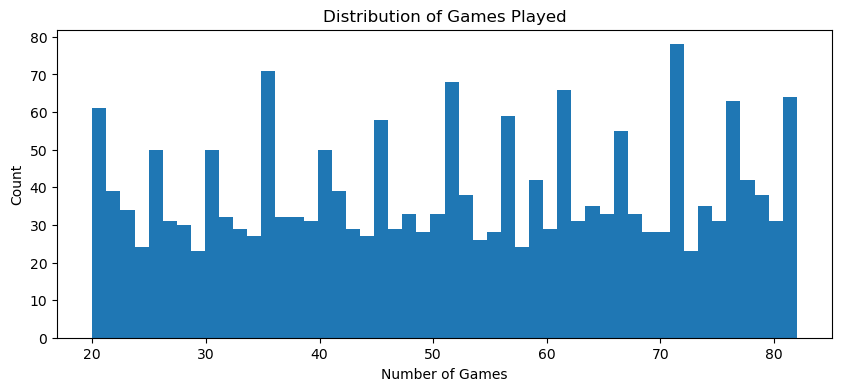

In [52]:
# Create histogram
plt.figure(figsize=(10, 4))
plt.hist(df['games_played'], bins=50)
plt.title('Distribution of Games Played')
plt.xlabel('Number of Games')
plt.ylabel('Count')
plt.show()

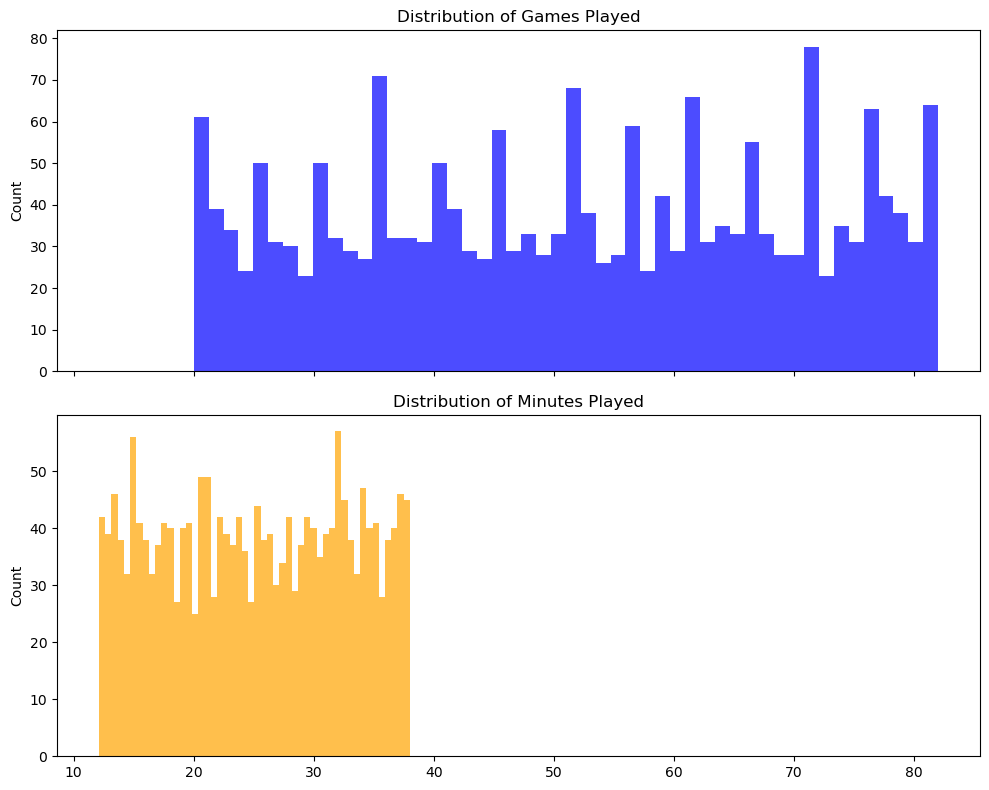

In [56]:
# Create subplots: one stacked on top of the other
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top histogram
axes[0].hist(df['games_played'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Distribution of Games Played')
axes[0].set_ylabel('Count')

# Bottom histogram (optional customization to show some variation)
axes[1].hist(df['minutes'], bins=50, color='orange', alpha=0.7)
axes[1].set_title('Distribution of Minutes Played')
#axes[1].set_xlabel('Number of Minutes Played')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


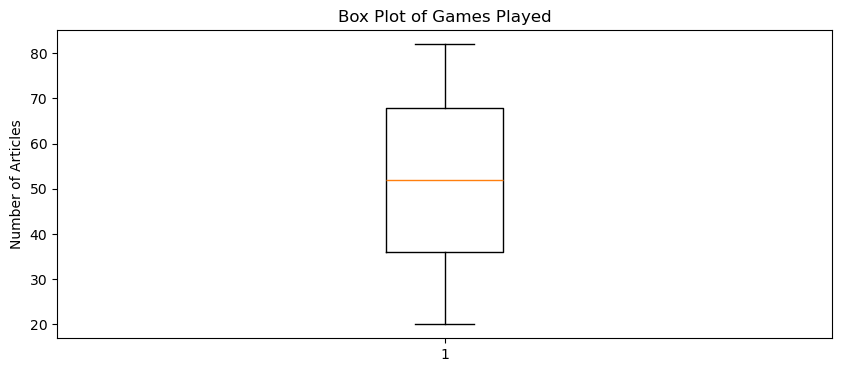

In [60]:
# Create box plot
plt.figure(figsize=(10, 4))
plt.boxplot(df.games_played)
plt.title('Box Plot of Games Played')
plt.ylabel('Number of Articles')
plt.show()